## Introduction

In today’s digital world, users are overwhelmed with the abundance of movie choices available across various platforms. As a result, deciding what to watch next has become increasingly difficult. Movie Recommendation Systems offer a practical solution to this issue by helping users discover movies tailored to their preferences, based on data and intelligent algorithms.

This project aims to build a Content-Based Movie Recommendation System that suggests similar movies to a given title using various metadata features such as genre, overview, cast, crew, and keywords. The recommendations are based on the similarity between movies, allowing the system to offer personalized suggestions without the need for explicit user ratings or interaction history.

## Data Descriptions

### All the features in the data set are defined as follows:


1. adult : Indicates whether the movie is for adults (True or False).
2. belongs_to_collection : Contains information about the collection or franchise the movie belongs to (if any), represented as a dictionary-like string.
3. budget : The budget of the movie in USD (as a string or numeric value).
4. genres : A list of genre objects (each with id and name) associated with the movie.
5. homepage : The official website URL of the movie (if available).
6. id : The unique identifier for the movie (may be numeric or string).
7. imdb_id : The IMDb identifier of the movie (e.g., tt0114709).
8. original_language : The original language in which the movie was produced (e.g., 'en' for English).
9. original_title : The original title of the movie (before translation/localization).
10. overview : A short summary or synopsis of the movie's plot.
11. popularity : A numeric score representing the movie's popularity (used for sorting or filtering).
12. poster_path : The file path to the movie’s poster image.
13. production_companies : A list of production companies involved in making the movie, usually as dictionary-like strings.
14. production_countries : A list of countries involved in production, also in dictionary-like format.
15. release_date : The official release date of the movie (in YYYY-MM-DD format).
16. revenue : The revenue generated by the movie (in USD).
17. runtime : The length of the movie in minutes.
18. spoken_languages : A list of spoken languages in the movie, represented as dictionaries.
19. status : The release status of the movie (e.g., Released, Post Production).
20. tagline : A short marketing tagline or catchphrase for the movie.
21. title : The title of the movie (may differ from the original title due to localization).
22. video : Indicates whether the entry is a video (True or False).
23. vote_average : The average user rating for the movie (on a scale, typically out of 10).
24. vote_count : The total number of votes or ratings the movie has received.

In [8]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import ast  # for parsing genre strings
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Load the movie metadata CSV file
df = pd.read_csv("movies_metadata.csv", low_memory=False)

In [12]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [14]:
movies = df[['title','genres','vote_average','popularity']].copy()

In [16]:
# Drop rows with missing values in important columns
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity'])

In [20]:
#Extract genre names from JSON-like string
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)      #safely parses a string that looks like a Python literal
        return [g['name'] for g in genres]
    except:
        return []

# Apply the parsing function to each row
movies['genre_list'] = movies['genres'].apply(parse_genres)

In [30]:
# Convert genre_list to binary vectors (one-hot encoding)
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# Select only numeric features and reset index
numeric_features = movies[['vote_average', 'popularity']].reset_index(drop=True)

# Combine numeric and genre features
combined_features = pd.concat([numeric_features, genre_df], axis=1)

# Normalize all features to [0,1] for clustering
scaler = MinMaxScaler()
final_features = scaler.fit_transform(combined_features)

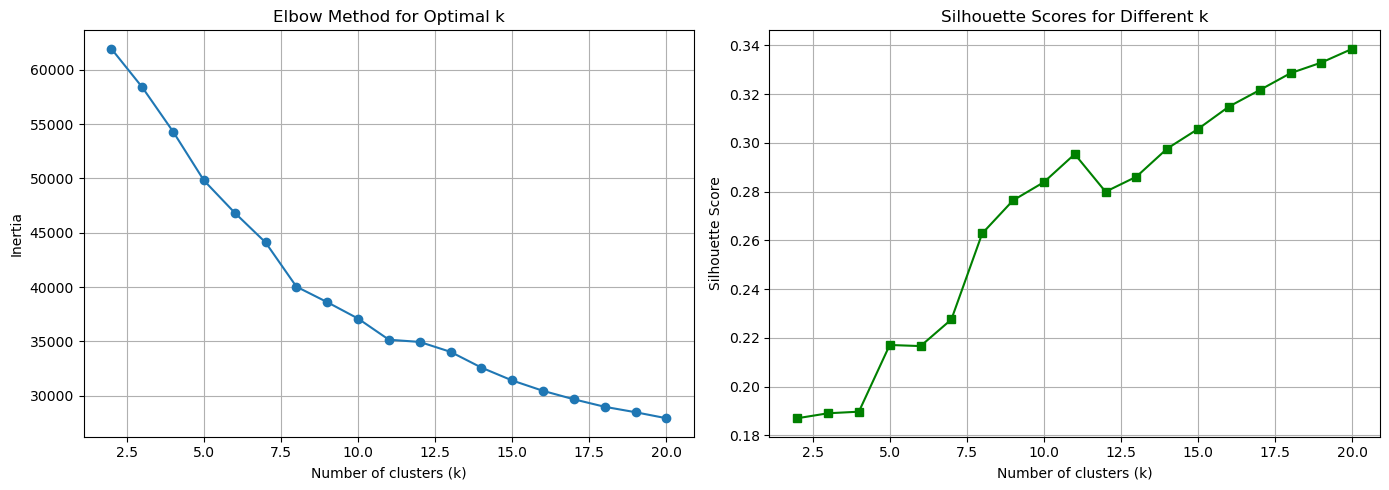

In [34]:
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

# KMeans Clustering & Metrics Calculation
for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10984\533219994.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


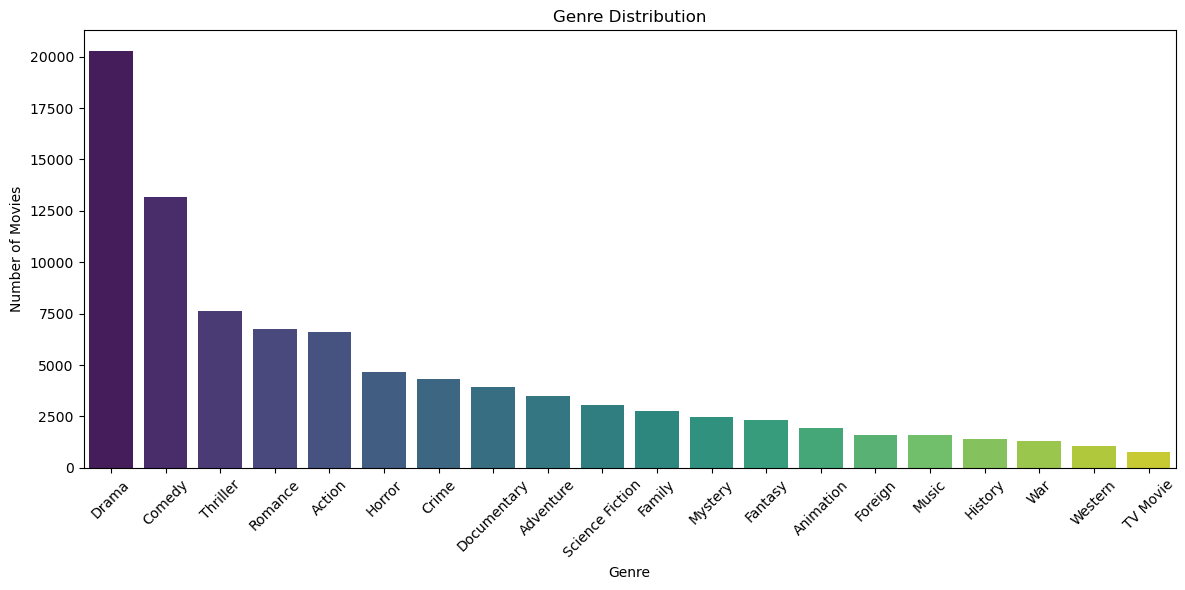

In [36]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [42]:
# We scale vote_average and popularity to range [0, 1]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])

In [44]:
#Combine all features into one matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10984\2550356348.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies['cluster'], palette='coolwarm')


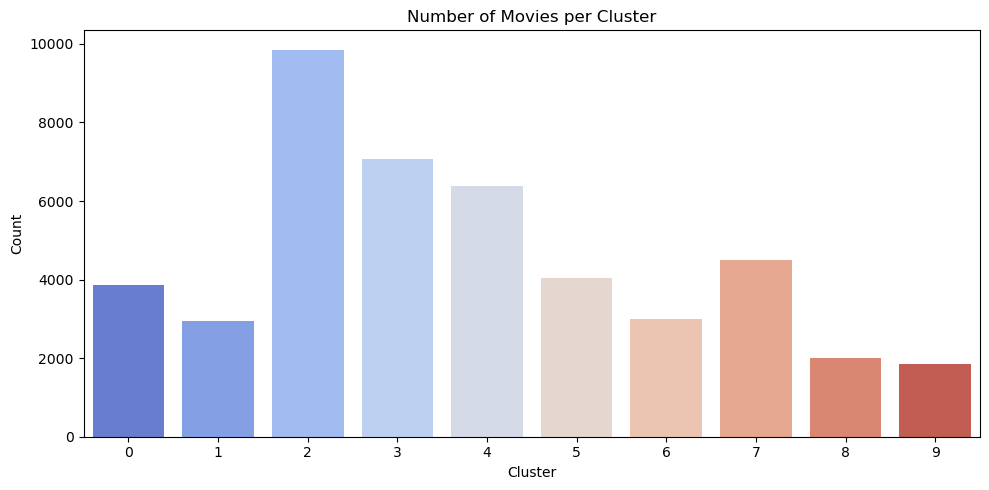

In [46]:
# Fit KMeans using chosen k (replace with optimal k from elbow plot)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [50]:
#Define recommendation function
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.
    
    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['title'].str.lower() == movie_title.lower()]
    
    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."
    
    # Get the cluster of the target movie
    cluster_id = target['cluster'].values[0]
    
    # Get all movies from the same cluster
    similar_movies = movies[(movies['cluster'] == cluster_id) & 
                            (movies['title'].str.lower() != movie_title.lower())]
    
    # Return top N based on vote_average and popularity
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)

In [52]:
print("Recommended movies similar to 'Heat':")
print(recommend_movies("Heat", n=5))

Recommended movies similar to 'Heat':
                                     title  vote_average popularity
24951                 Deliver Us from Evil          10.0   0.317373
39707                     American Hostage          10.0    0.11167
22346                       هیچ کجا هیچ کس          10.0   0.070407
25355                 The Great Kidnapping          10.0   0.049823
41698  Paradies 505. Ein Niederbayernkrimi          10.0   0.048331


In [54]:
print("Recommended movies similar to 'The Lion King':")
print(recommend_movies("The Lion King", n=5))

Recommended movies similar to 'The Lion King':
                                 title  vote_average popularity
41695          Крепость: щитом и мечом          10.0   0.349582
25689     Back to School with Franklin          10.0   0.040437
20943                  King of Katoren           9.5    0.36934
42155  Kizumonogatari Part 3: Reiketsu           9.4   3.519786
30233                          Tony 10           9.0   0.412313


In [56]:
print("Recommended movies similar to 'Mad Max: Fury Road':")
print(recommend_movies("Mad Max: Fury Road", n=5))

Recommended movies similar to 'Mad Max: Fury Road':
                title  vote_average popularity
42179    Patient Zero          10.0   1.083454
44629     Tokyo Ghoul          10.0   0.802191
28152  Goodbye & Amen          10.0   0.596517
40269         Killjoy          10.0    0.15623
31615         Bipolar           9.0   0.543602
